# Multiclass cancer diagnosis using tumor gene expression signatures

In this assignment, we tried to replicate a portion of the experiments described in [this](https://www.pnas.org/doi/10.1073/pnas.211566398) paper.

218 snap-frozen tumoral samples, as well as 90 normal samples, were collected from patients with multiple types of cancer. The idea behind these experiments will be to use gene expression signatures to predict the types of cancer present in the samples and to try and offer a generalisation over a SVM model.

## Chapter 1: Describing the data

The experiments will be conducted on snap-frozen human tumor and normal tissue specimens, spanning 14 different tumor classes. Such materials were originally collected from the National Cancer Institute/Cooperative Human Tissue Network, Massachusetts General Hospital Tumor Bank, Dana–Farber Cancer Institute, Brigham and other such institutions in Boston area.

218 cancerous samples, as well as 90 healthy samples, were then subjected to oligonucleotide microarray gene expression analysis.

Oligonucleotide microarray gene expression analysis is a technique used to measure the expression levels of large numbers of genes simultaneously. This technique is used to study the expression of thousands of genes at once, and to identify genes that are differentially expressed in different samples.

![microarray](./microarray.png)

## Chapter 2: Exploring the data

Once we understood the kind of data we were dealing with, we started by loading the data and exploring it.

In [1]:
import polars as pl

dirty = pl.read_csv("data/GCM_Total.res", separator="\t", truncate_ragged_lines=True)

print(dirty.head())

dirty.describe()

shape: (5, 563)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Descriptio ┆ Accession  ┆ Tumor__Bre ┆      ┆ … ┆ _duplicate ┆ Normal__C ┆ _duplicat ┆ _duplicat │
│ n          ┆ ---        ┆ ast_Adeno_ ┆ ---  ┆   ┆ d_277      ┆ erebellum ┆ ed_278    ┆ ed_279    │
│ ---        ┆ str        ┆ 09-B_003A  ┆ str  ┆   ┆ ---        ┆ _Brain_Nc ┆ ---       ┆ ---       │
│ str        ┆            ┆ ---        ┆      ┆   ┆ str        ┆ er_S-…    ┆ str       ┆ str       │
│            ┆            ┆ f64        ┆      ┆   ┆            ┆ ---       ┆           ┆           │
│            ┆            ┆            ┆      ┆   ┆            ┆ i64       ┆           ┆           │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ null       ┆ null       ┆ null       ┆ null ┆ … ┆ null       ┆ null      ┆ null      ┆ null      │
│ AFFX-BioB- ┆ AFFX-BioB- ┆ -64.3      ┆ A    ┆ … ┆ A          ┆ -90       

statistic,Description,Accession,Tumor__Breast_Adeno_09-B_003A,,Tumor__Breast_Adeno_09-B_005A,_duplicated_0,Tumor__Breast_Adeno_92_I_078,_duplicated_1,Tumor__Breast_Adeno_93_I_192,_duplicated_2,Tumor__Breast_Adeno_93_I_250,_duplicated_3,Tumor__Breast_Adeno_94_I_155,_duplicated_4,Tumor__Breast_Adeno_94_I_159,_duplicated_5,Tumor__Breast_Adeno_95_I_029,_duplicated_6,Tumor__Breast_Adeno_9912c068_CC,_duplicated_7,Tumor__Breast_Adeno_mBRT1_(8697),_duplicated_8,Tumor__Breast_Adeno_mBRT2_(9078),_duplicated_9,Tumor__Prostate_Adeno_94_I_052,_duplicated_10,Tumor__Prostate_Adeno_95_I_249,_duplicated_11,Tumor__Prostate_Adeno_95_I_256,_duplicated_12,Tumor__Prostate_Adeno_LocalCaP10T,_duplicated_13,Tumor__Prostate_Adeno_LocalCaP1T,_duplicated_14,Tumor__Prostate_Adeno_P_0025,_duplicated_15,…,Normal__Pancreas_Pan13N,_duplicated_261,Normal__Pancreas_Pan_14N,_duplicated_262,Normal__Pancreas_Pan_43N,_duplicated_263,Normal__Pancreas_Pan_42N,_duplicated_264,Normal__Pancreas_Pan_40N,_duplicated_265,Normal__Pancreas_Pan_41N,_duplicated_266,Normal__Pancreas_OV_1,_duplicated_267,Normal__Ovary_OV_2,_duplicated_268,Normal__Ovary_OV_3,_duplicated_269,Normal__Ovary_OV_4,_duplicated_270,Normal__Whole_Brain_BRAIN_1,_duplicated_271,Normal__Whole_Brain_BRAIN_2,_duplicated_272,Normal__Whole_Brain_BRAIN_3,_duplicated_273,Normal__Whole_Brain_BRAIN_4,_duplicated_274,Normal__Whole_Brain_BRAIN_5,_duplicated_275,Normal__Cerebellum_Brain_Ncer_NCB1,_duplicated_276,Normal__Cerebellum_Brain_Ncer_S-51,_duplicated_277,Normal__Cerebellum_Brain_Ncer_S-125,_duplicated_278,_duplicated_279
str,str,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,…,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,str
"""count""","""16063""","""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",…,16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""","""0"""
"""null_count""","""1""","""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",…,1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""","""16064"""
"""mean""",null,null,46.132211,null,17.945527,null,167.069974,null,16.928469,null,82.844923,null,31.268879,null,33.377825,null,81.76754,null,74.395816,null,26.59995,null,23.171388,null,264.75926,null,31.306792,null,190.747432,null,212.180103,null,175.499533,null,486.394073,null,…,48.55494,null,16.999938,null,18.00884,null,22.133288,null,36.949636,null,18.411505,null,248.076387,null,204.467161,null,153.623663,null,633.144649,null,462.351429,null,124.607857,null,389.946262,null,196.246,null,376.868704,null,474.184455,null,394.028388,null,343.556061,null,null
"""std""",null,null,393.452575,null,294.26962,null,611.572681,null,255.75055,null,468.294695,null,233.358432,null,187.341336,null,469.891508,null,443.67566,null,251.664362,null,228.72525,null,962.057611,null,265.719834,null,907.94976,null,789.732744,null,716.349317,null,1395.743932,null,…,382.850505,null,239.489302,null,252.552377,null,242.8251,null,382.390101

The first thing we noticed is the file format in which these files were provided. Instead `.csv` files, we had `.res` files, whose format we weren't familiar with before encountering this dataset. 

We did find [this](https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats) page that describes the formats, but offers little help in how to read them in python.

It must be noted that there seems to be no python package that deals with these files directly, so we had to make do and treat them as text files for the time being.
The following cell will be used for this activity.

In [2]:
def clean_column_names(data: pl.DataFrame) -> pl.DataFrame:
    new_columns = []
    for i, col in enumerate(data.columns):
        if "duplicated" in col:
            new_col = f"{data.columns[i-1]}_class"
        elif col == "":
            new_col = f"{data.columns[i-1]}_class"
        else:
            new_col = col
        new_columns.append(new_col)

    data.columns = new_columns

    return data


ds = clean_column_names(dirty)

ds.describe()

statistic,Description,Accession,Tumor__Breast_Adeno_09-B_003A,Tumor__Breast_Adeno_09-B_003A_class,Tumor__Breast_Adeno_09-B_005A,Tumor__Breast_Adeno_09-B_005A_class,Tumor__Breast_Adeno_92_I_078,Tumor__Breast_Adeno_92_I_078_class,Tumor__Breast_Adeno_93_I_192,Tumor__Breast_Adeno_93_I_192_class,Tumor__Breast_Adeno_93_I_250,Tumor__Breast_Adeno_93_I_250_class,Tumor__Breast_Adeno_94_I_155,Tumor__Breast_Adeno_94_I_155_class,Tumor__Breast_Adeno_94_I_159,Tumor__Breast_Adeno_94_I_159_class,Tumor__Breast_Adeno_95_I_029,Tumor__Breast_Adeno_95_I_029_class,Tumor__Breast_Adeno_9912c068_CC,Tumor__Breast_Adeno_9912c068_CC_class,Tumor__Breast_Adeno_mBRT1_(8697),Tumor__Breast_Adeno_mBRT1_(8697)_class,Tumor__Breast_Adeno_mBRT2_(9078),Tumor__Breast_Adeno_mBRT2_(9078)_class,Tumor__Prostate_Adeno_94_I_052,Tumor__Prostate_Adeno_94_I_052_class,Tumor__Prostate_Adeno_95_I_249,Tumor__Prostate_Adeno_95_I_249_class,Tumor__Prostate_Adeno_95_I_256,Tumor__Prostate_Adeno_95_I_256_class,Tumor__Prostate_Adeno_LocalCaP10T,Tumor__Prostate_Adeno_LocalCaP10T_class,Tumor__Prostate_Adeno_LocalCaP1T,Tumor__Prostate_Adeno_LocalCaP1T_class,Tumor__Prostate_Adeno_P_0025,Tumor__Prostate_Adeno_P_0025_class,…,Normal__Pancreas_Pan13N,Normal__Pancreas_Pan13N_class,Normal__Pancreas_Pan_14N,Normal__Pancreas_Pan_14N_class,Normal__Pancreas_Pan_43N,Normal__Pancreas_Pan_43N_class,Normal__Pancreas_Pan_42N,Normal__Pancreas_Pan_42N_class,Normal__Pancreas_Pan_40N,Normal__Pancreas_Pan_40N_class,Normal__Pancreas_Pan_41N,Normal__Pancreas_Pan_41N_class,Normal__Pancreas_OV_1,Normal__Pancreas_OV_1_class,Normal__Ovary_OV_2,Normal__Ovary_OV_2_class,Normal__Ovary_OV_3,Normal__Ovary_OV_3_class,Normal__Ovary_OV_4,Normal__Ovary_OV_4_class,Normal__Whole_Brain_BRAIN_1,Normal__Whole_Brain_BRAIN_1_class,Normal__Whole_Brain_BRAIN_2,Normal__Whole_Brain_BRAIN_2_class,Normal__Whole_Brain_BRAIN_3,Normal__Whole_Brain_BRAIN_3_class,Normal__Whole_Brain_BRAIN_4,Normal__Whole_Brain_BRAIN_4_class,Normal__Whole_Brain_BRAIN_5,Normal__Whole_Brain_BRAIN_5_class,Normal__Cerebellum_Brain_Ncer_NCB1,Normal__Cerebellum_Brain_Ncer_NCB1_class,Normal__Cerebellum_Brain_Ncer_S-51,Normal__Cerebellum_Brain_Ncer_S-51_class,Normal__Cerebellum_Brain_Ncer_S-125,Normal__Cerebellum_Brain_Ncer_S-125_class,_duplicated_278_class
str,str,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,…,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,str
"""count""","""16063""","""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",…,16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""","""0"""
"""null_count""","""1""","""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",…,1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""","""16064"""
"""mean""",null,null,46.132211,null,17.945527,null,167.069974,null,16.928469,null,82.844923,null,31.268879,null,33.377825,null,81.76754,null,74.395816,null,26.59995,null,23.171388,null,264.75926,null,31.306792,null,190.747432,null,21

After a small amount of name normalisation, we end up with a usable dataframe that we can employ for our analysis.

While there aren't many rows, we have a huge amount of columns, 2 for each gene, one for the gene expression value and one for the gene class.

We identified 3 classes of gene expression:
- `M`: Marginal
- `A`: Absent
- `P`: Present

We decided to focus our research on finding out whether the presence of some genes are directly related to the type of cancer present in the sample.

We also repeated the same procedure for the normal samples.

In [3]:
dirty = pl.read_csv("data/GCM_Normal.res", separator="\t", truncate_ragged_lines=True)

normal_ds = clean_column_names(dirty)

normal_ds.describe()

statistic,Description,Accession,Normal__Breast_BR_1,Normal__Breast_BR_1_class,Normal__Breast_BR_2,Normal__Breast_BR_2_class,Normal__Breast_BR_3,Normal__Breast_BR_3_class,Normal__Breast_BR_4,Normal__Breast_BR_4_class,Normal__Breast_93_I_184,Normal__Breast_93_I_184_class,Normal__Prostate_PR_2,Normal__Prostate_PR_2_class,Normal__Prostate_PR_3,Normal__Prostate_PR_3_class,Normal__Prostate_PR_4,Normal__Prostate_PR_4_class,Normal__Prostate_PR_5,Normal__Prostate_PR_5_class,Normal__Prostate_PR_6,Normal__Prostate_PR_6_class,Normal__Prostate_PR_7,Normal__Prostate_PR_7_class,Normal__Prostate_NLP1N,Normal__Prostate_NLP1N_class,Normal__Prostate_NLP10N,Normal__Prostate_NLP10N_class,Normal__Prostate_95_I_255,Normal__Prostate_95_I_255_class,Normal__Lung_LU_1,Normal__Lung_LU_1_class,Normal__Lung_LU_2,Normal__Lung_LU_2_class,Normal__Lung_LU_3,Normal__Lung_LU_3_class,…,Normal__Pancreas_Pan_11N_class,Normal__Pancreas_Pan13N,Normal__Pancreas_Pan13N_class,Normal__Pancreas_Pan_14N,Normal__Pancreas_Pan_14N_class,Normal__Pancreas_Pan_43N,Normal__Pancreas_Pan_43N_class,Normal__Pancreas_Pan_42N,Normal__Pancreas_Pan_42N_class,Normal__Pancreas_Pan_40N,Normal__Pancreas_Pan_40N_class,Normal__Pancreas_Pan_41N,Normal__Pancreas_Pan_41N_class,Normal__Pancreas_OV_1,Normal__Pancreas_OV_1_class,Normal__Ovary_OV_2,Normal__Ovary_OV_2_class,Normal__Ovary_OV_3,Normal__Ovary_OV_3_class,Normal__Ovary_OV_4,Normal__Ovary_OV_4_class,Normal__Whole_Brain_BRAIN_1,Normal__Whole_Brain_BRAIN_1_class,Normal__Whole_Brain_BRAIN_2,Normal__Whole_Brain_BRAIN_2_class,Normal__Whole_Brain_BRAIN_3,Normal__Whole_Brain_BRAIN_3_class,Normal__Whole_Brain_BRAIN_4,Normal__Whole_Brain_BRAIN_4_class,Normal__Whole_Brain_BRAIN_5,Normal__Whole_Brain_BRAIN_5_class,Normal__Cerebellum_Brain_Ncer_NCB1,Normal__Cerebellum_Brain_Ncer_NCB1_class,Normal__Cerebellum_Brain_Ncer_S-51,Normal__Cerebellum_Brain_Ncer_S-51_class,Normal__Cerebellum_Brain_Ncer_S-125,Normal__Cerebellum_Brain_Ncer_S-125_class
str,str,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,…,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str,f64,str
"""count""","""16063""","""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",…,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063""",16063.0,"""16063"""
"""null_count""","""1""","""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",…,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1""",1.0,"""1"""
"""mean""",null,null,358.598518,null,547.872004,null,546.922493,null,250.243448,null,59.737658,null,253.51989,null,378.08654,null,461.83683,null,222.339476,null,360.66345,null,487.166034,null,240.436531,null,179.91801,null,170.005727,null,396.955924,null,730.92517,null,286.033306,null,…,null,48.55494,null,16.999938,null,18.00884,null,22.133288,null,36.949636,null,18.411505,null,248.076387,null,204.467161,null,153.623663,null,633.144649,null,462.351429,null,124.607857,null,389.946262,null,196.246,null,376.868704,null,474.184455,null,39

## Chapter 3: Tentative processing

In [10]:
classes = [col for col in ds.columns if "class" in col]
mutations_df = ds.select(["Accession"] + classes)

mutations_df = mutations_df.with_columns(
    pl.Series(
        "PRESENT", mutations_df.map_rows(lambda s: sum([1 for i in s if i == "P"]))
    )
)

summed = (
    mutations_df.sort("PRESENT", descending=True).select(["Accession", "PRESENT"])
)

summed.head(20)

Accession,PRESENT
str,i64
"""M26880_at""",280
"""U44839_at""",280
"""AA422123_f_at""",280
"""H89133_s_at""",280
"""K00629_f_at""",280
…,…
"""RC_AA448627_f_…",277
"""D21261_at""",276
"""L38941_at""",276


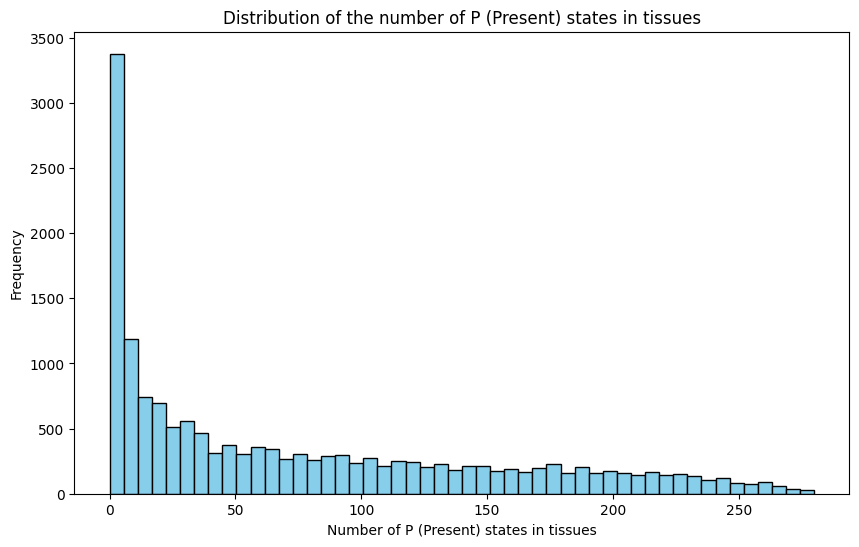

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(mutations_df["PRESENT"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Number of P (Present) states in tissues")
plt.ylabel("Frequency")
plt.title("Distribution of the number of P (Present) states in tissues")
plt.show()


## Chapter 4: SVMs (WIP)

For the time being, we haven't finished implementing the SVM yet, as we are still figuring out the architecture.

In the meantime, we have experimented with a simpler Neural Network model, as a proxy for the SVM.

In [6]:
# Feature Engineering
# Here we will use FeatureWiz to create new features based on the existing ones

# ML Pipeline
import torch as tch
from torch import nn

from itertools import islice, tee
from typing import Iterable, TypeVar, Iterator

T = TypeVar("T") # PY3.11 generics syntax

# Given an iterable, this function returns a sliding window of the given size
# Ex: sliding_window([1, 2, 3, 4, 5], 3) -> [(1, 2, 3), (2, 3, 4), (3, 4, 5)]
# It gives the SimpleNeuralNetwork api a way to create layers of the given size
def sliding_window(iterable: Iterable[T], size: int) -> Iterator[tuple[T, ...]]:
    iterables = tee(iter(iterable), size)
    window = zip(*(islice(t, n, None) for n, t in enumerate(iterables)))
    yield from window


class SimpleNeuralNetwork(tch.nn.Module):
    def __init__(
        self,
        input_n: int,
        output_n: int,
        weights_size: tuple[int, ...],
        *args: object,
        **kwargs: object,
    ) -> None:
        super().__init__(*args, **kwargs)

        # Variable number of layers, based on the provides sizes
        layers = list[tch.nn.Linear]()
        sizes = sliding_window([input_n, *weights_size, output_n], 2)

        for in_size, out_size, *_ in sizes:
            layer = tch.nn.Linear(in_size, out_size)
            layers.append(layer)

        self.layers = nn.ModuleList(layers)

    def forward(self, x: tch.Tensor) -> tch.Tensor:
        for index, layer in enumerate(self.layers):
            if index == len(self.layers) - 1:
                x = tch.nn.functional.softmax(layer(x))
            else:
                # One point of improvement: Maybe relu is not the best activation function
                x = tch.nn.functional.relu(layer(x))

        return x


def tch_train_model(
    X_train: tch.Tensor,
    y_train: tch.Tensor,
    loss_function: tch.nn.Module,
    size: tuple[int, ...],
    eta: float,
    epochs: int,
    verbose: bool = False,
) -> tuple[SimpleNeuralNetwork, list[float], list[float]]:
    losses = list[float]()
    accuracies = list[float]()

    model = SimpleNeuralNetwork(X_train.shape[1], len(y_train.unique()), size)

    optimiser = tch.optim.Adam(model.parameters(), lr=eta)

    for epoch in range(1, epochs + 1):
        # Zero the gradients
        optimiser.zero_grad()

        # Forward pass
        output = model(X_train_tensor)

        # Calculate the loss
        loss = loss_function(output, y_train_tensor)

        # Backward pass
        loss.backward()

        # Update the weights
        optimiser.step()

        # Log the loss
        if epoch % 25 == 0:
            if verbose:
                print(f"Epoch {epoch} loss: {loss.item()}")

            losses.append(loss.item())
            accuracies.append(
                (tch.argmax(output, dim=1) == y_train_tensor).sum().item()
                / len(y_train_tensor)
            )

    return model, losses, accuracies


def tch_evaluate_model(
    model: SimpleNeuralNetwork, X_test: tch.Tensor, y_test: tch.Tensor
) -> float:
    with tch.no_grad():
        # Get the predictions
        predictions = model(X_test)

        # Get the predicted classes
        predicted_classes = tch.argmax(predictions, dim=1)

        # Calculate the accuracy
        accuracy = (predicted_classes == y_test).sum().item() / len(y_test)

    return accuracy


def tch_plot_model(
    losses: list[float],
    accuracies: list[float],
    epochs: int,
    size: tuple[int, ...],
    eta: float,
    loss_function: tch.nn.Module,
    framework: str,
) -> None:
    # Plot the losses
    plt.plot(range(1, epochs + 1, int(epochs / len(losses))), losses)
    plt.title(
        f"{framework} Neural Network Loss with layers of size {size},"
        f" learning rate {eta} and loss function {loss_function}"
    )
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.show()

    # Plot the accuracies
    plt.plot(range(1, epochs + 1, int(epochs / len(losses))), accuracies)
    plt.title(
        f"{framework} Neural Network Accuracy with layers of size {size}"
        f" learning rate {eta} and loss function {loss_function}"
    )
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy (%)")
    plt.show()


def tch_pipeline(
    size: tuple[int, ...],
    eta: float,
    epochs: int,
    X_train: tch.Tensor,
    y_train: tch.Tensor,
    X_test: tch.Tensor,
    y_test: tch.Tensor,
    loss_function: tch.nn.Module,
    framework: str = "PyTorch",
) -> None:
    model, losses, accuracies = tch_train_model(
        X_train, y_train, loss_function, size, eta, epochs
    )

    accuracy = tch_evaluate_model(model, X_test, y_test)

    print(f"Accuracy on training set: {accuracies[-1] * 100}%")
    print(f"Accuracy on test set: {accuracy * 100}%")

    tch_plot_model(losses, accuracies, epochs, size, eta, loss_function, framework)


sizes: list[tuple[int, ...]] = [
    (16, 32), # One hidden layer
    (64, 128), # One Hidden Layer
    (32, 32, 32, 32), # Three Hidden Layers [(IN, 32), (32, 32), (32, 32), (32, 32), (32, OUT)]
    (64, 128, 128, 64), # Three Hidden Layers
    (24, 48, 192, 48, 24), # Four Hidden Layers
]

lrs = [0.0003, 0.003] # Learning rates

loss_functions: list[nn.Module] = [tch.nn.CrossEntropyLoss(), tch.nn.NLLLoss()] # Tinkering with loss functions


# Here itertools.product is sadly not the best choice because we lose type information
tch_parameters = [
    (size, lr, loss_function)
    for size in sizes
    for lr in lrs
    for loss_function in loss_functions
]


## Chapter 5: Pending Questions

- Is it meaningful to focus on the gene expression value and transforming our data into a binary classification problem?
- On the same vein, does it make sense to transform a `.res` file into a `.gct` file? (Thus ignoring the `A`, `M` and `P` values and focusing on the gene expression values only), so we might use [gseapy](https://github.com/zqfang/GSEApy). 

In [7]:
#  remove columns if the column name includes _class to remove A M and P columns

def remove_everything_but_class_labels(data: pl.DataFrame) -> pl.DataFrame:
    for col in data.columns:
        if "_class" not in col and col != "Accession" and col != "Description":
            data = data.drop(col)

    return data

def remove_class_labels(data: pl.DataFrame) -> pl.DataFrame:
    for col in data.columns:
        if "_class" in col:
            data = data.drop(col)

    return data


# Remove the columns that are not class labels
# ds = remove_class_labels(ds)

# Remove the columns that are not class labels
normal_ds = remove_class_labels(normal_ds)
    

print(ds.head())



shape: (5, 563)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Descripti ┆ Accession ┆ Tumor__Br ┆ Tumor__Br ┆ … ┆ Normal__C ┆ Normal__C ┆ Normal__C ┆ _duplica │
│ on        ┆ ---       ┆ east_Aden ┆ east_Aden ┆   ┆ erebellum ┆ erebellum ┆ erebellum ┆ ted_278_ │
│ ---       ┆ str       ┆ o_09-B_00 ┆ o_09-B_00 ┆   ┆ _Brain_Nc ┆ _Brain_Nc ┆ _Brain_Nc ┆ class    │
│ str       ┆           ┆ 3A        ┆ 3A_cl…    ┆   ┆ er_S-…    ┆ er_S-…    ┆ er_S-…    ┆ ---      │
│           ┆           ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│           ┆           ┆ f64       ┆ str       ┆   ┆ str       ┆ i64       ┆ str       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ null      ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ AFFX-BioB ┆ AFFX-BioB ┆ -64.3     ┆ A         ┆ … ┆ A         ┆ -90      

# VGG 16

In [8]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x